# import Library

In [2]:
import sys
sys.path.append('../')
from my_library.library import *

# path ubu

In [ ]:
path_daw = '/home/hipro/デスクトップ/StockPriceData/Stock_index/DAW_10years.csv'
path_tpx = '/home/hipro/デスクトップ/StockPriceData/Stock_index/TOPIX_10years.csv'


# path mac

In [6]:
path_tpx = '/Users/rince/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/rince/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_bear = '/Users/rince/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'
path_doll = '/Users/rince/Desktop/StockPriceData/Stock_index/doll_yen_bid.csv'
path_gold = '/Users/rince/Desktop/StockPriceData/Stock_index/gold_chusin.csv'
path_kawase = '/Users/rince/Desktop/StockPriceData/Stock_index/quote.csv'

# path win

In [4]:
path_tpx = '/Users/Owner/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/Owner/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/Owner/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_bear = '/Users/Owner/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'

path_tpx_sim = '/Users/Owner/Desktop/StockPriceData/TOPIX/TOPIX_20211208.csv'
path_daw_sim = '/Users/Owner/Desktop/StockPriceData/DAW/DAW_20211208.csv'

# 相関係数求め方

In [ ]:
x_,y_,_,_ = lx.make_xgb_data(path_tpx,path_daw,0.8)


In [ ]:
year = 2021
x = df_con[df_con.index.year==year]['daw_close'].values
y = df_con[df_con.index.year==year]['close'].values
coef = np.corrcoef(x,y)

In [ ]:
strong_corr = []
x_corr = x_.corr()
for idx in x_corr.index:
    for col in x_corr.columns:
        if idx == col:
            continue
        else:
            corr = x_corr.loc[idx][col]
            if abs(corr)>=0.8:
                strong_corr.append([idx,col])

# 相関の強い特徴量をどうするか

差分取ってみる

差分とっても相関強いまま

In [ ]:
strong_corr

# 為替

In [ ]:
df_kawase = pd.read_csv(path_kawase, index_col=0,encoding='Shift_JIS')
column_name = df_kawase.iloc[0]
df_kawase = df_kawase.set_axis(df_kawase.iloc[1].values.tolist(),axis=1).iloc[2:]
df_kawase.dropna(how='all',axis=1,inplace=True)
df_kawase.replace('*****',np.nan,inplace=True)
df_kawase = df_kawase.astype('float64')
df_kawase['day'] = pd.to_datetime(df_kawase.index,format='%Y/%m/%d')
df_kawase.set_index('day',inplace=True)
# classes

In [ ]:
# pd.concat(df_kawase['USD'],df_con['close'])
df_corr = pd.DataFrame()
close = df_con['close']
USD = df_kawase['USD']

df_corr['close'] = (close-close.mean())/close.std()
df_corr['USD'] = (USD-USD.mean())/USD.std()
# df_corr['close'] =

# Learn XGB

[09:54:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


---------------------
AUC train: 0.8308524331977981
AUC test : 0.6724830795262268
              precision    recall  f1-score   support

           0       0.61      0.60      0.61       394
           1       0.63      0.65      0.64       420

    accuracy                           0.62       814
   macro avg       0.62      0.62      0.62       814
weighted avg       0.62      0.62      0.62       814



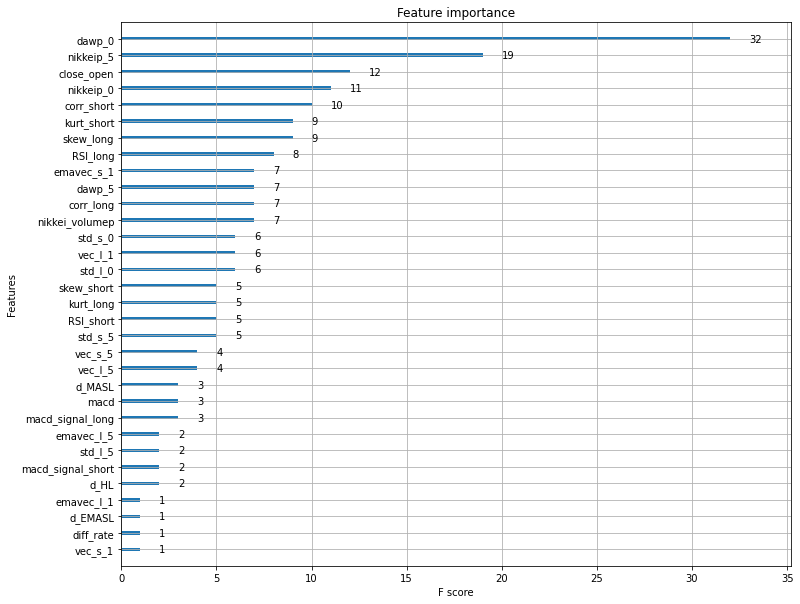

In [7]:
lx = LearnXGB()
lx.learn_xgb(path_tpx,path_daw)

# 市場平均だと, 年間収益は220

In [ ]:
for alpha in [0.5,0.6,0.7,0.8,0.9]:
    sl = XGBSimulation(lx.model,alpha=alpha)
    sl.simulate(path_tpx_sim,path_daw_sim,strategy='reverse',start_year=2021,start_month=1,end_month=12,is_observed=True)

In [ ]:
alpha=0.7
for month in range(1,12):
    sl = XGBSimulation(lx.model,alpha=alpha)
    sl.simulate(path_tpx_sim,path_daw_sim,strategy='reverse',start_year=2021,start_month=month,end_month=month)

# predict tomorrow

Total profit :22.0
Trade count  :12
Max profit   :135.5
Min profit   :-43.0
Mean profit  :1.8333333333333333
can't buy count 2
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.740741       0.73913        0.741935       0.68     0.793103    25.0   

   down_num  
0      29.0  



<Figure size 432x288 with 0 Axes>

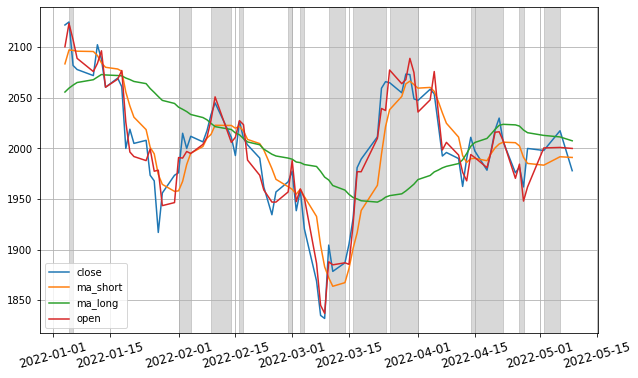

is_bought True
df_con in predict_tomorrow 2022-05-09 00:00:00
today : 2022-05-09 00:00:00
tomorrow UP possibility 0.123401575


In [5]:
path_tpx_sim, path_daw_sim = return_latest_data_path('TOPIX')

lx.predict_tomorrow(path_tpx_sim,path_daw_sim,alpha=0.6,strategy='normal',start_year=2022,start_month=1,end_month=5,is_observed=True)

Total profit :-110.0
Trade count  :13
Max profit   :43.5
Min profit   :-96.0
Mean profit  :-8.461538461538462
can't buy count 0
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.724138      0.708333        0.735294   0.653846      0.78125    26.0   

   down_num  
0      32.0  



<Figure size 432x288 with 0 Axes>

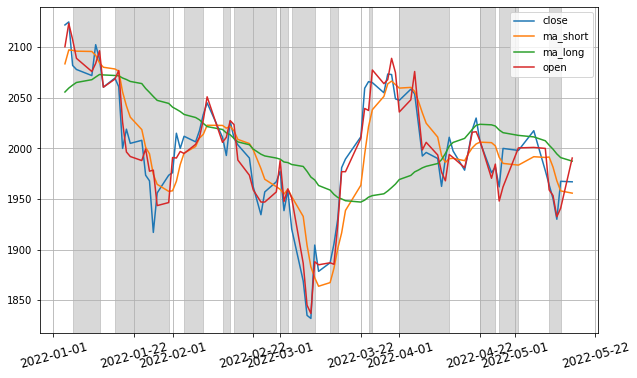

is_bought True
df_con in predict_tomorrow 2022-05-16 00:00:00
today : 2022-05-16 00:00:00
tomorrow UP possibility 0.41736543


In [9]:
path_tpx_sim, path_daw_sim = return_latest_data_path('TOPIX')


lx.predict_tomorrow(path_tpx_sim,path_daw_sim,alpha=0.6,strategy='reverse',start_year=2022,start_month=1,end_month=5,is_observed=False)

In [ ]:
(61/2500)*100

In [ ]:
# AI 6.2%
#TOPIX 2.4%

# 累積収益率　比較

In [ ]:
pr_log_xn = {}
for alpha in [0.5,0.6,0.7,0.8,0.9]:
    print("*************************")
    print('alpha :',alpha)
    sl = XGBSimulation(lx.model,alpha=alpha)
    pr_tmp = sl.return_profit_rate(path_tpx_sim,path_daw_sim,wallet=2500,strategy='normal')
    pr_tmp = pr_tmp[pr_tmp.index.year==2021]
    pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
    pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])
    pr_log_xn[alpha] = pr_tmp

In [ ]:
plt.subplots(figsize=(10, 6))
plt.plot(pr_log_xn[0.5]['eval_reward'],label='normal_0.5')
plt.plot(pr_log_xn[0.6]['eval_reward'],label='normal_0.6')
plt.plot(pr_log_xn[0.7]['eval_reward'],label='normal_0.7')
plt.plot(pr_log_xn[0.8]['eval_reward'],label='normal_0.8')
plt.plot(pr_log_xn[0.9]['eval_reward'],label='normal_0.9')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pr_log_xr = {}
for alpha in [0.5,0.6,0.7,0.8,0.9]:
    print("*************************")
    print('alpha :',alpha)
    sl = XGBSimulation(lx.model,alpha=alpha)
    pr_tmp = sl.return_profit_rate(path_tpx_sim,path_daw_sim,wallet=2500,strategy='reverse')
    pr_tmp = pr_tmp[pr_tmp.index.year==2021]
    pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
    pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])
    pr_log_xr[alpha] = pr_tmp

In [ ]:
plt.subplots(figsize=(10, 6))
plt.plot(pr_log_xr[0.5]['eval_reward'],label='reverse_0.5')
plt.plot(pr_log_xr[0.6]['eval_reward'],label='reverse_0.6')
plt.plot(pr_log_xr[0.7]['eval_reward'],label='reverse_0.7')
plt.plot(pr_log_xr[0.8]['eval_reward'],label='reverse_0.8')
plt.plot(pr_log_xr[0.9]['eval_reward'],label='reverse_0.9')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.subplots(figsize=(10, 6))
plt.plot(pr_log_tpx['reward'].iloc[:-2],label='TOPIX')
plt.plot(pr_log_t[pr_log_t.index.year==2021]['eval_reward'].iloc[:-2],label='Technical')
plt.plot(pr_log_xr[0.9]['eval_reward'],label='reverse_0.9')
plt.plot(pr_log_xn[0.5]['eval_reward'],label='normal_0.5')
plt.legend()
plt.grid(True)
plt.show()